In [1]:
from os import listdir, mkdir
from os.path import join, isfile, isdir
import shutil
import json

import numpy as np
import skimage
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

win_root = 'C:/'
nix_root = '/mnt/c/'
image_an_folder = win_root + 'Users/bhaladik/mrcnn_development/training_data/custom_training1'
print(isdir(image_an_folder))

True


In [2]:
#filepath = image_an_folder + "/add_nuclei_11_annotated.json"
filepath = image_an_folder + "/add_nuclei_12_partially_annotated_corrected.json"
in_file = open(filepath, 'r')
annotation_json = json.load(in_file)
in_file.close()

In [3]:
print(annotation_json.keys())

dict_keys(['_via_settings', '_via_img_metadata', '_via_attributes', '_via_data_format_version', '_via_image_id_list'])


In [4]:
#print(annotation_json['_via_img_metadata'])
annotation = annotation_json['_via_img_metadata']
print(annotation.keys())

dict_keys(['add_nuclei_1.png39426', 'add_nuclei_2.png41144', 'add_nuclei_3.png26307', 'add_nuclei_4.png22082', 'add_nuclei_5.png40092', 'add_nuclei_6.png117354', 'add_nuclei_7.png66678', 'add_nuclei_8.png132497', 'add_nuclei_9.png71328', 'add_nuclei_10.png52914', 'add_nuclei_11.png54986', 'add_nuclei_12.png60171', 'add_nuclei_13.png36454', 'add_nuclei_14.png70213', 'add_nuclei_15.png84068', 'add_nuclei_16.png44034', 'add_nuclei_17.png63138', 'add_nuclei_18.png27954', 'add_nuclei_19.png51410', 'add_nuclei_20.png72452'])


In [6]:
print(annotation['add_nuclei_1.png39426']['regions'])

[{'shape_attributes': {'name': 'polygon', 'all_points_x': [22, 24, 28, 29, 29, 26, 23, 22, 21], 'all_points_y': [77, 80, 79, 77, 73, 71, 71, 74, 76]}, 'region_attributes': {}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [88, 92, 93, 93, 93, 92, 91, 90, 87, 86, 83, 82, 81, 82, 86], 'all_points_y': [56, 57, 60, 63, 65, 66, 67, 68, 68, 68, 66, 64, 61, 58, 56]}, 'region_attributes': {}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [120, 119, 119, 120, 122, 124, 124, 125, 126, 128, 129, 129, 128, 127, 126, 126, 126, 125], 'all_points_y': [0, 2, 3, 6, 6, 7, 6, 8, 8, 8, 7, 5, 3, 3, 3, 2, 1, 0]}, 'region_attributes': {}}, {'shape_attributes': {'name': 'polygon', 'all_points_x': [125, 127, 128, 128, 128, 128, 128, 128, 128, 128, 127, 126, 126, 125, 124, 123, 122, 121, 121, 121, 121, 122, 123, 124], 'all_points_y': [124, 125, 126, 127, 129, 131, 132, 132, 134, 135, 135, 135, 134, 133, 133, 133, 132, 132, 131, 129, 127, 125, 125, 124]}, 'region_attributes': {}}, {'shape

In [7]:
def get_regions_from_jsondict(in_json, regionkey='regions', shattr_key='shape_attributes', x_key='all_points_x', y_key='all_points_y'):
    """
    Should return tuple: (names, nested coordinates)
    nested coordinates are returned in the format y,x ie matrix coordinate format
    """
    image_names = list(in_json.keys())
    image_names.sort()
    nested_out_coords =  []
    for imname in image_names:
        subdict = in_json[imname]
        region_dicts = subdict[regionkey]
        coords_per_image = []
        for rdict in region_dicts:
            sh_attrs = rdict[shattr_key]
            x_coords = sh_attrs[x_key]
            y_coords = sh_attrs[y_key]
            coords_per_image.append(list(zip(y_coords, x_coords)))
        nested_out_coords.append(coords_per_image)
    return image_names, nested_out_coords

def get_im_shape_from_coords(in_list):
    return

def draw_polygon(height, width, coords):
    image = np.zeros((height, width))
    if isinstance(coords, list):
        coords = np.array(coords)
    coords = coords.reshape((-1,1,2))
    y_coords_tmp = coords[:,:,0].copy()
    coords[:,:,0] = coords[:,:,1]
    coords[:,:,1] = y_coords_tmp
    #coords[:,:,1] = width - coords[:,:,1]
    #coords[:,:,0] = height - coords[:,:,0]
    #cv2.polylines(image, [coords], True, True)
    cv2.fillPoly(image, [coords], True)
    return image.astype(np.bool)

def json_to_mask_array(in_json, imsizes=None):
    ### infers smallest possible image size from maximum x and y coordinates if imsizes is None
    ### so passing image sizes makes more sense of course
    names, nested_coords = get_regions_from_jsondict(in_json)
    out_arrays = []
    for i in range(len(nested_coords)):
        coords = nested_coords[i]
        if not (imsizes is None):
            if isinstance(imsizes, list) and isinstance(imsizes[0], list):
                height = imsizes[i][0]
                width = imsizes[i][1]
            else:
                height = imsizes[0]
                width = imsizes[1]
        else:
            height, width = get_im_shape_from_coords(coords)
        out_arr = np.zeros((height, width, len(coords))).astype(np.bool)
        for k in range(len(coords)):
            out_arr[:,:,k] = draw_polygon(height, width, coords[k])
            if (i == 0) and (k < 3):
                fig, ax = plt.subplots(figsize=(10,10))
                ax.imshow(out_arr[:,:,k])
                fig.show()
        ### function to draw polygons goes here
        out_arrays.append(out_arr)
    return names, out_arrays

<ipython-input-7-8031ec2350b7>:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


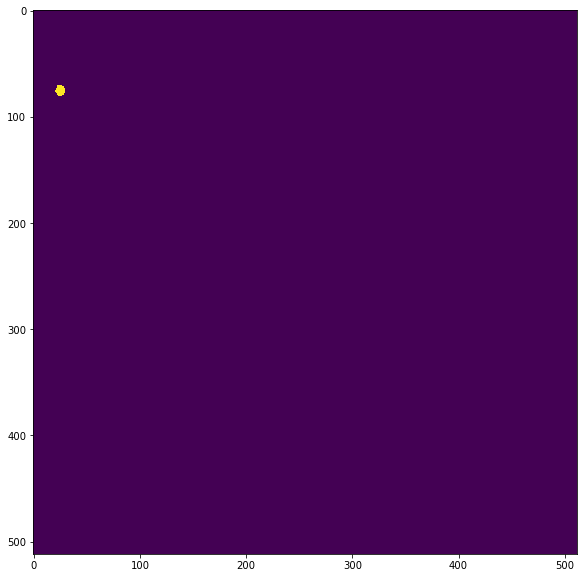

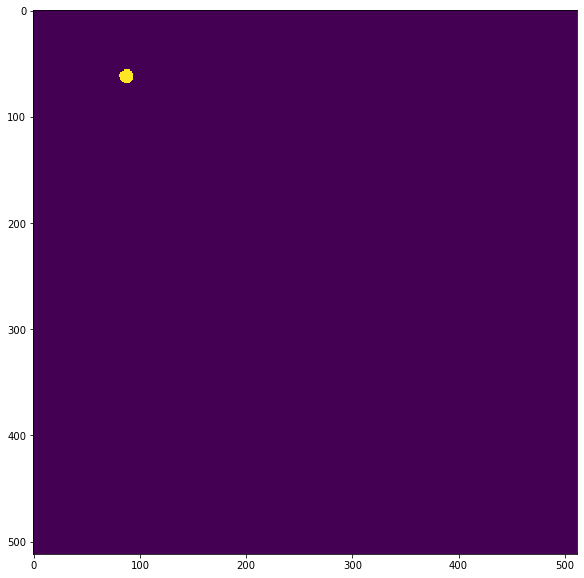

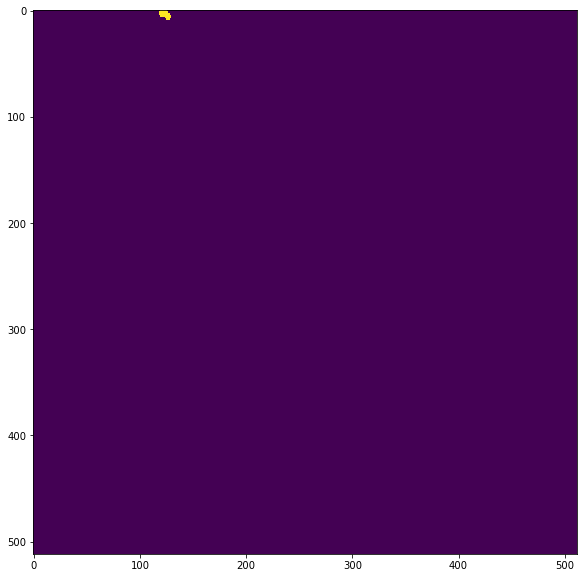

In [8]:
image_names, mask_arrays = json_to_mask_array(annotation, imsizes=(512,512))

In [9]:
print(image_names[:3])

['add_nuclei_1.png39426', 'add_nuclei_10.png52914', 'add_nuclei_11.png54986']


In [10]:
print(len(mask_arrays))

20


In [11]:
type(mask_arrays[0])

numpy.ndarray

<ipython-input-12-3313c5871dd1>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


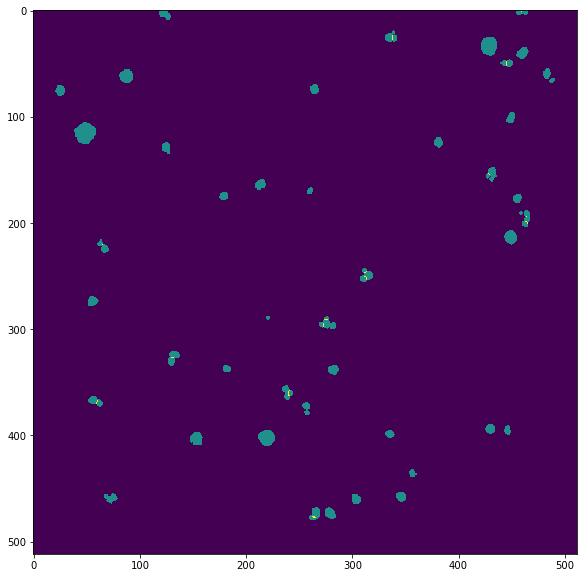

In [12]:
## make image out of first mask array to compare with original image
show_im = np.zeros((512,512))
masks_here = mask_arrays[0]
for i in range(masks_here.shape[2]):
    m = masks_here[:,:,i]
    show_im += m #* (i+1)
    
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(show_im)
fig.show()

In [31]:
def reformat_name(in_name, file_ending='.png'):
    prefix, _ = in_name.split(file_ending)
    return prefix + file_ending

def create_annotation_data_folder(annotation, orig_image_folder, target_folder, file_ending='.png', stop_image=None):
    if not isdir(target_folder):
        mkdir(target_folder)
    image_names, mask_arrays = json_to_mask_array(annotation, imsizes=(512,512))
    for i in range(len(image_names)):
        use_name = reformat_name(image_names[i], file_ending=file_ending)
        use_prefix, _ = use_name.split(file_ending)
        if not (stop_image is None):
            if stop_image in use_prefix:
                print('Reached stop image. Ending')
                break
        orig_im_path = join(orig_image_folder, use_name)
        target_im_folder = join(target_folder, use_prefix)
        mkdir(target_im_folder)
        target_im_folder_im = join(target_im_folder, 'images')
        mkdir(target_im_folder_im)
        target_im_folder_mask = join(target_im_folder, 'masks')
        mkdir(target_im_folder_mask)
        shutil.copy(orig_im_path, target_im_folder_im)
        m_arr = mask_arrays[i]
        for k in range(m_arr.shape[2]):
            target_path = join(target_im_folder_mask, use_prefix + str(k) + file_ending)
            cv2.imwrite(target_path, m_arr[:,:,k] * 255)
        print('Finished writing images and masks for image ' + use_name)
    return

In [32]:
target_folder = win_root + 'Users/bhaladik/mrcnn_development/training_data/inhouse_data'

<ipython-input-7-8031ec2350b7>:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Finished writing images and masks for image add_nuclei_1.png
Finished writing images and masks for image add_nuclei_10.png
Finished writing images and masks for image add_nuclei_11.png
Finished writing images and masks for image add_nuclei_12.png
Finished writing images and masks for image add_nuclei_13.png
Finished writing images and masks for image add_nuclei_14.png
Finished writing images and masks for image add_nuclei_15.png
Finished writing images and masks for image add_nuclei_16.png
Finished writing images and masks for image add_nuclei_17.png
Finished writing images and masks for image add_nuclei_18.png
Finished writing images and masks for image add_nuclei_19.png
Finished writing images and masks for image add_nuclei_2.png
Finished writing images and masks for image add_nuclei_20.png
Finished writing images and masks for image add_nuclei_3.png
Finished writing images and masks for image add_nuclei_4.png
Finished writing images and masks for image add_nuclei_5.png
Finished writ

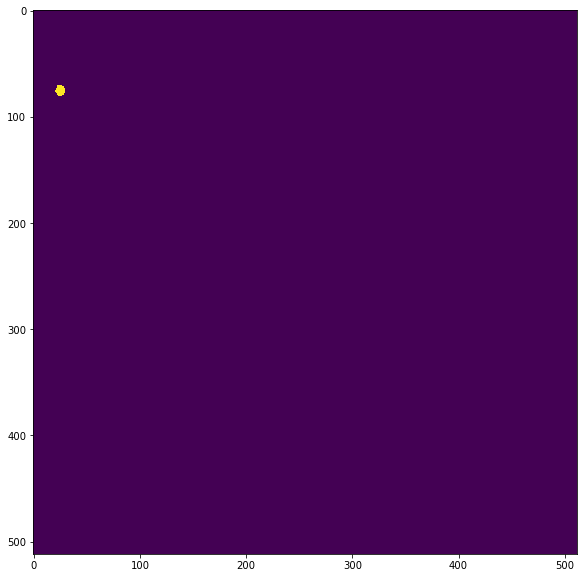

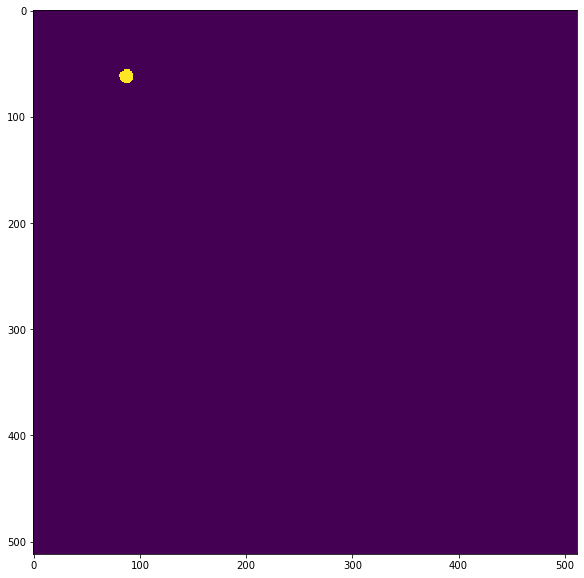

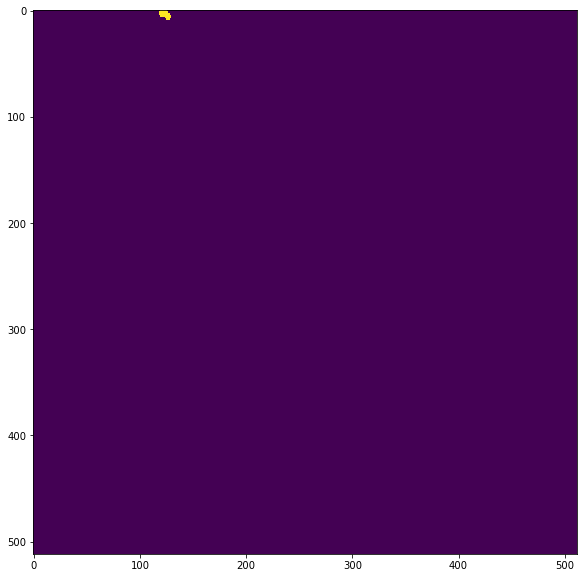

In [33]:
create_annotation_data_folder(annotation, image_an_folder, target_folder, stop_image=None)